# Import

In [ ]:
!pip install -q segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
import os
import random
from glob import glob
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision import transforms, models

import segmentation_models_pytorch as smp
import timm
from segmentation_models_pytorch.decoders.unet.decoder import UnetDecoder
import torch.optim as optim

torch.cuda.empty_cache()
torch.cuda.synchronize()
import gc
gc.collect()
torch.cuda.empty_cache()

# Helper functions

In [ ]:
def dice_coefficient(preds, targets, smooth=1e-6):
    # preds and targets are torch tensors with shape [B, 1, H, W]
    preds = (preds > 0.5).float()  # binarize predictions
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean().item()  # mean over batch

def dice_score(pred, target, smooth=1e-6):
    """Computes Dice coefficient for binary masks."""
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1e-6):
    """Computes Intersection over Union (Jaccard index)."""
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

# U-Net from scratch

### Dataset

In [ ]:
image_dir = r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/dataset/ISIC_images"
mask_dir = r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/dataset/ISIC_masks"

# Check that each image has its correspondent mask
print('images:', len(os.listdir(image_dir)))
print('masks:', len(os.listdir(image_dir)))

images: 1000
masks: 1000


In [ ]:
all_images = sorted(glob(os.path.join(image_dir, '*')))
all_masks = sorted(glob(os.path.join(mask_dir, '*')))

# Get image base names (without extension)
image_names = [os.path.splitext(os.path.basename(p))[0] for p in all_images]

# Get mask base names and remove _segmentation suffix
mask_names = [os.path.splitext(os.path.basename(p))[0].replace('_segmentation','') for p in all_masks]

# Check for missing masks
missing_masks = [name for name in image_names if name not in mask_names]
missing_images = [name for name in mask_names if name not in image_names]

if not missing_masks and not missing_images:
    print("All images have corresponding masks!")
else:
    print(f'Missing masks for images: {missing_masks}')
    print(f'Missing images for masks: {missing_images}')

All images have corresponding masks!


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, img_size):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.img_size = img_size

        # Define transforms for image and mask (resize + to tensor)
        self.image_transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor()  # automatically converts to [0,1] float tensor
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize(img_size, interpolation=Image.NEAREST),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L') # grayscale

        img = self.image_transform(img)
        mask = self.mask_transform(mask)

        return img, mask

In [ ]:
# Create pairs of image + mask
pairs = [(i,m) for i,m in zip(all_images, all_masks)]
random.shuffle(pairs)

### Split into training, validation and test

# Compute split indices
total = len(pairs)
train_end = int(0.8 * total)
val_end = int(0.9 * total)  # next 10% for validation, last 10% for test

# Split the pairs
train_pairs = pairs[:train_end]
val_pairs = pairs[train_end:val_end]
test_pairs = pairs[val_end:]

# Separate images and masks
train_imgs, train_masks = zip(*train_pairs)
val_imgs, val_masks = zip(*val_pairs)
test_imgs, test_masks = zip(*test_pairs)


### Create datasets

# define output image and mask size
img_size = (224,224)

train_ds = SegmentationDataset(train_imgs, train_masks, img_size=img_size)
val_ds = SegmentationDataset(val_imgs, val_masks, img_size=img_size)
test_ds = SegmentationDataset(test_imgs, test_masks, img_size=img_size)


### Create dataloaders

# define batch size
batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


### Check dimensions
img, mask = train_ds[0]
print(f"Image shape: {img.shape}")   # (C, H, W)
print(f"Mask shape: {mask.shape}")   # (1, H, W)

img, mask = val_ds[0]
print(f"\nImage shape: {img.shape}")   # (C, H, W)
print(f"Mask shape: {mask.shape}")   # (1, H, W)

img, mask = test_ds[0]
print(f"\nImage shape: {img.shape}")   # (C, H, W)
print(f"Mask shape: {mask.shape}")   # (1, H, W)


Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([1, 224, 224])

Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([1, 224, 224])

Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([1, 224, 224])


In [ ]:
imgs, masks = next(iter(train_loader))
print(imgs.shape)  # should be (batch_size, C, H, W)
print(masks.shape) # should be (batch_size, C, H, W)


torch.Size([32, 3, 224, 224])
torch.Size([32, 1, 224, 224])


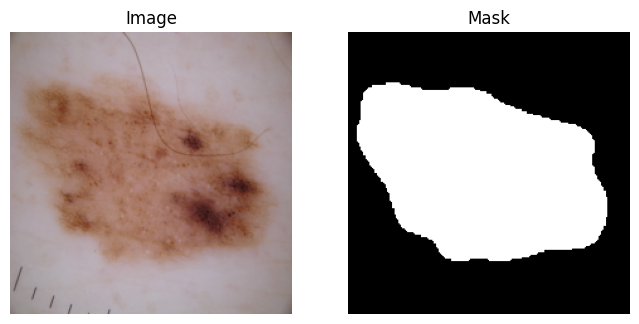

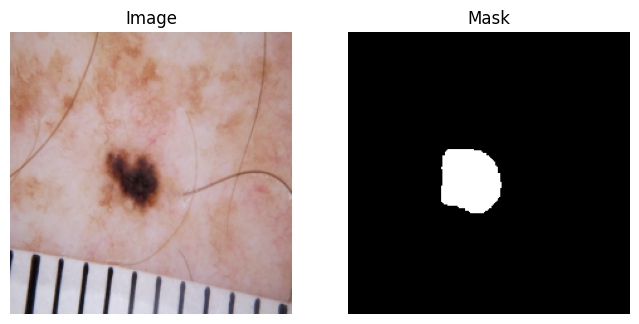

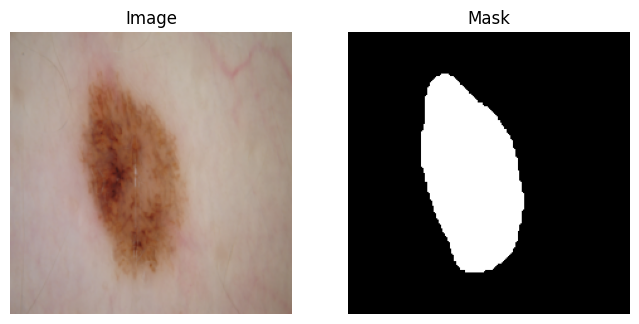

In [ ]:
import matplotlib.pyplot as plt

def show_examples(dataset, n=3):
    for i in range(n):
        img, mask = dataset[i]

        img_np = img.permute(1, 2, 0).numpy()  # (C,H,W) -> (H,W,C)
        mask_np = mask.squeeze(0).numpy()      # (1,H,W) -> (H,W)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(img_np)
        ax[0].set_title("Image")
        ax[0].axis('off')

        ax[1].imshow(mask_np, cmap='gray')
        ax[1].set_title("Mask")
        ax[1].axis('off')

        plt.show()

# Show 3 examples from the training dataset
show_examples(test_ds, n=3)


### Model definition

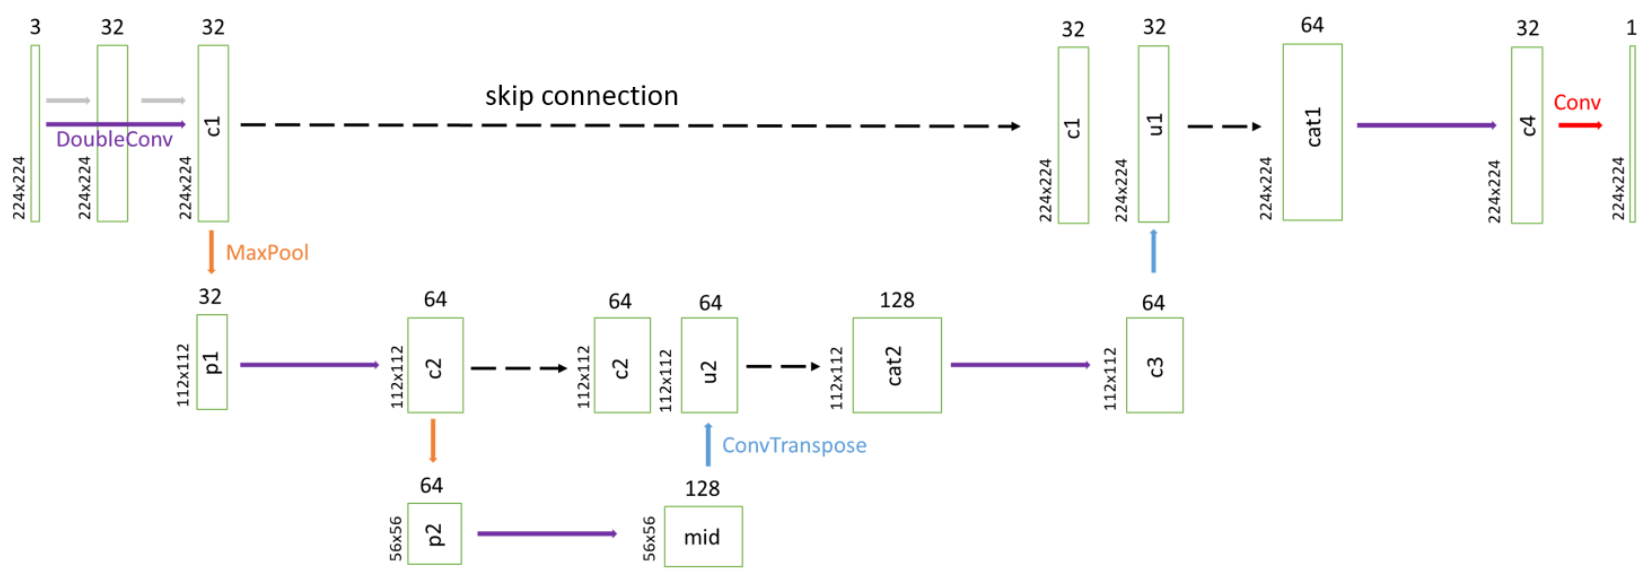

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)

class BasicUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(BasicUNet, self).__init__()
        self.down1 = DoubleConv(n_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.middle = DoubleConv(64, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(64, 32)

        self.out_conv = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        c1 = self.down1(x)
        p1 = self.pool1(c1)
        c2 = self.down2(p1)
        p2 = self.pool2(c2)

        mid = self.middle(p2)

        u2 = self.up2(mid)
        cat2 = torch.cat([u2, c2], dim=1)
        c3 = self.conv2(cat2)

        u1 = self.up1(c3)
        cat1 = torch.cat([u1, c1], dim=1)
        c4 = self.conv1(cat1)

        out = self.out_conv(c4)
        return torch.sigmoid(out)  # output between 0 and 1


### Model training

In [ ]:
# --- Model initialization ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BasicUNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- Scheduler & Early stopping ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
patience = 10
best_val_loss = float("inf")
epochs_no_improve = 0

# --- Training loop ---
n_epochs = 100
train_losses, val_losses = [], []
train_dices, val_dices = [], []

for epoch in range(n_epochs):
    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0.0
    train_dice = 0.0
    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch [{epoch+1}/{n_epochs}]")

    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coefficient(outputs, masks)

        loop.set_postfix(loss=loss.item(), dice=dice_coefficient(outputs, masks))

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)
    train_losses.append(train_loss)
    train_dices.append(train_dice)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_dice += dice_coefficient(outputs, masks)

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_losses.append(val_loss)
    val_dices.append(val_dice)

    scheduler.step(val_loss)

    print(f"\nEpoch [{epoch+1}/{n_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

    # ---------------- EARLY STOPPING ----------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model_unet.pth")
        print("💾 Saved new best model.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("🛑 Early stopping triggered!")
        break


cuda


Epoch [1/100]: 100%|██████████| 25/25 [01:20<00:00,  3.22s/it, dice=0.713, loss=0.374]



Epoch [1/100] | Train Loss: 0.5226 | Train Dice: 0.5932 | Val Loss: 0.5326 | Val Dice: 0.4037
💾 Saved new best model.


Epoch [2/100]: 100%|██████████| 25/25 [01:10<00:00,  2.82s/it, dice=0.633, loss=0.444]



Epoch [2/100] | Train Loss: 0.4350 | Train Dice: 0.6458 | Val Loss: 0.6462 | Val Dice: 0.5911
No improvement for 1 epoch(s).


Epoch [3/100]: 100%|██████████| 25/25 [01:12<00:00,  2.90s/it, dice=0.724, loss=0.359]



Epoch [3/100] | Train Loss: 0.4035 | Train Dice: 0.6756 | Val Loss: 0.5503 | Val Dice: 0.5840
No improvement for 2 epoch(s).


Epoch [4/100]: 100%|██████████| 25/25 [01:09<00:00,  2.79s/it, dice=0.712, loss=0.358]



Epoch [4/100] | Train Loss: 0.3774 | Train Dice: 0.6987 | Val Loss: 0.4823 | Val Dice: 0.6747
💾 Saved new best model.


Epoch [5/100]: 100%|██████████| 25/25 [01:09<00:00,  2.78s/it, dice=0.694, loss=0.382]



Epoch [5/100] | Train Loss: 0.3681 | Train Dice: 0.6982 | Val Loss: 0.6536 | Val Dice: 0.6728
No improvement for 1 epoch(s).


Epoch [6/100]: 100%|██████████| 25/25 [01:08<00:00,  2.74s/it, dice=0.716, loss=0.325]



Epoch [6/100] | Train Loss: 0.3507 | Train Dice: 0.7152 | Val Loss: 0.5346 | Val Dice: 0.6563
No improvement for 2 epoch(s).


Epoch [7/100]: 100%|██████████| 25/25 [01:07<00:00,  2.71s/it, dice=0.745, loss=0.323]



Epoch [7/100] | Train Loss: 0.3270 | Train Dice: 0.7300 | Val Loss: 0.4673 | Val Dice: 0.7242
💾 Saved new best model.


Epoch [8/100]: 100%|██████████| 25/25 [01:07<00:00,  2.69s/it, dice=0.738, loss=0.379]



Epoch [8/100] | Train Loss: 0.3256 | Train Dice: 0.7380 | Val Loss: 0.3513 | Val Dice: 0.6655
💾 Saved new best model.


Epoch [9/100]: 100%|██████████| 25/25 [01:07<00:00,  2.72s/it, dice=0.753, loss=0.318]



Epoch [9/100] | Train Loss: 0.3130 | Train Dice: 0.7410 | Val Loss: 0.4622 | Val Dice: 0.6980
No improvement for 1 epoch(s).


Epoch [10/100]: 100%|██████████| 25/25 [01:07<00:00,  2.68s/it, dice=0.728, loss=0.345]



Epoch [10/100] | Train Loss: 0.3130 | Train Dice: 0.7513 | Val Loss: 0.5530 | Val Dice: 0.7086
No improvement for 2 epoch(s).


Epoch [11/100]: 100%|██████████| 25/25 [01:07<00:00,  2.70s/it, dice=0.809, loss=0.255]



Epoch [11/100] | Train Loss: 0.3134 | Train Dice: 0.7428 | Val Loss: 0.3948 | Val Dice: 0.7231
No improvement for 3 epoch(s).


Epoch [12/100]: 100%|██████████| 25/25 [01:08<00:00,  2.73s/it, dice=0.759, loss=0.288]



Epoch [12/100] | Train Loss: 0.3007 | Train Dice: 0.7586 | Val Loss: 0.2938 | Val Dice: 0.7424
💾 Saved new best model.


Epoch [13/100]: 100%|██████████| 25/25 [01:07<00:00,  2.69s/it, dice=0.749, loss=0.296]



Epoch [13/100] | Train Loss: 0.2965 | Train Dice: 0.7585 | Val Loss: 0.3695 | Val Dice: 0.7390
No improvement for 1 epoch(s).


Epoch [14/100]: 100%|██████████| 25/25 [01:07<00:00,  2.70s/it, dice=0.848, loss=0.213]



Epoch [14/100] | Train Loss: 0.2923 | Train Dice: 0.7667 | Val Loss: 0.2876 | Val Dice: 0.7418
💾 Saved new best model.


Epoch [15/100]: 100%|██████████| 25/25 [01:07<00:00,  2.70s/it, dice=0.775, loss=0.315]



Epoch [15/100] | Train Loss: 0.2975 | Train Dice: 0.7636 | Val Loss: 0.4283 | Val Dice: 0.7169
No improvement for 1 epoch(s).


Epoch [16/100]: 100%|██████████| 25/25 [01:07<00:00,  2.70s/it, dice=0.776, loss=0.266]



Epoch [16/100] | Train Loss: 0.2855 | Train Dice: 0.7746 | Val Loss: 0.3679 | Val Dice: 0.7189
No improvement for 2 epoch(s).


Epoch [17/100]: 100%|██████████| 25/25 [01:08<00:00,  2.73s/it, dice=0.796, loss=0.293]



Epoch [17/100] | Train Loss: 0.2859 | Train Dice: 0.7735 | Val Loss: 0.2865 | Val Dice: 0.7586
💾 Saved new best model.


Epoch [18/100]: 100%|██████████| 25/25 [01:07<00:00,  2.69s/it, dice=0.729, loss=0.29] 



Epoch [18/100] | Train Loss: 0.2873 | Train Dice: 0.7733 | Val Loss: 0.4258 | Val Dice: 0.7068
No improvement for 1 epoch(s).


Epoch [19/100]: 100%|██████████| 25/25 [01:07<00:00,  2.70s/it, dice=0.832, loss=0.212]



Epoch [19/100] | Train Loss: 0.2805 | Train Dice: 0.7768 | Val Loss: 0.3364 | Val Dice: 0.7512
No improvement for 2 epoch(s).


Epoch [20/100]: 100%|██████████| 25/25 [01:14<00:00,  2.97s/it, dice=0.818, loss=0.222]



Epoch [20/100] | Train Loss: 0.2772 | Train Dice: 0.7786 | Val Loss: 0.3399 | Val Dice: 0.6918
No improvement for 3 epoch(s).


Epoch [21/100]: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, dice=0.739, loss=0.299]



Epoch [21/100] | Train Loss: 0.2740 | Train Dice: 0.7853 | Val Loss: 0.4092 | Val Dice: 0.6525
No improvement for 4 epoch(s).


Epoch [22/100]: 100%|██████████| 25/25 [01:12<00:00,  2.88s/it, dice=0.765, loss=0.225]



Epoch [22/100] | Train Loss: 0.2732 | Train Dice: 0.7853 | Val Loss: 0.3085 | Val Dice: 0.7523
No improvement for 5 epoch(s).


Epoch [23/100]: 100%|██████████| 25/25 [01:12<00:00,  2.89s/it, dice=0.791, loss=0.247]



Epoch [23/100] | Train Loss: 0.2720 | Train Dice: 0.7877 | Val Loss: 0.3773 | Val Dice: 0.7430
No improvement for 6 epoch(s).


Epoch [24/100]: 100%|██████████| 25/25 [01:13<00:00,  2.95s/it, dice=0.877, loss=0.193]



Epoch [24/100] | Train Loss: 0.2640 | Train Dice: 0.7980 | Val Loss: 0.2879 | Val Dice: 0.7691
No improvement for 7 epoch(s).


Epoch [25/100]: 100%|██████████| 25/25 [01:12<00:00,  2.90s/it, dice=0.796, loss=0.231]



Epoch [25/100] | Train Loss: 0.2547 | Train Dice: 0.7988 | Val Loss: 0.3739 | Val Dice: 0.7482
No improvement for 8 epoch(s).


Epoch [26/100]: 100%|██████████| 25/25 [01:06<00:00,  2.67s/it, dice=0.791, loss=0.252]



Epoch [26/100] | Train Loss: 0.2576 | Train Dice: 0.7951 | Val Loss: 0.2952 | Val Dice: 0.7704
No improvement for 9 epoch(s).


Epoch [27/100]: 100%|██████████| 25/25 [01:07<00:00,  2.69s/it, dice=0.8, loss=0.215]  



Epoch [27/100] | Train Loss: 0.2481 | Train Dice: 0.8024 | Val Loss: 0.3090 | Val Dice: 0.7611
No improvement for 10 epoch(s).
🛑 Early stopping triggered!


### Model evaluation

cuda


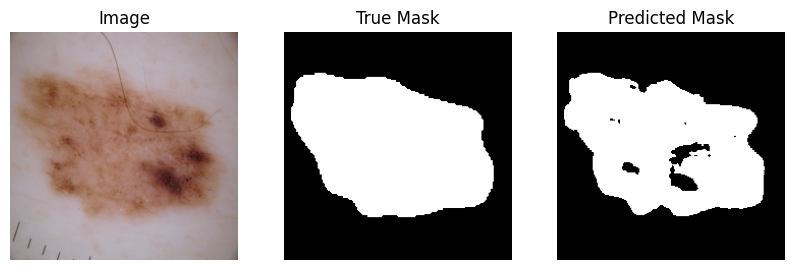

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BasicUNet().to(device)
model.load_state_dict(torch.load(r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/best_model_unet.pth"))

model.eval()
with torch.no_grad():
    img, true_mask = test_ds[0]
    input_tensor = img.unsqueeze(0).to(device)
    output = model(input_tensor)
    pred_mask = output[0,0].cpu().numpy()

# Threshold to binary
binary_mask = (pred_mask > 0.5).astype("uint8")

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img.permute(1,2,0)); plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(true_mask.squeeze(), cmap="gray"); plt.title("True Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(binary_mask, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
plt.show()


In [ ]:
def predict_scores(dataset):
    dice_scores = []
    iou_scores = []

    model.eval()
    with torch.no_grad():
        for img, true_mask in tqdm(dataset, desc="Evaluating"):
            # Move image to device
            input_tensor = img.unsqueeze(0).to(device)

            # Forward pass
            output = model(input_tensor)
            pred_mask = output[0, 0].cpu().numpy()

            # Binarize predictions and ground truth
            pred_bin = (pred_mask > 0.5).astype(np.uint8)
            true_bin = true_mask.squeeze().numpy().astype(np.uint8)

            # Compute metrics
            dice = dice_score(pred_bin, true_bin)
            iou = iou_score(pred_bin, true_bin)

            dice_scores.append(dice)
            iou_scores.append(iou)

    # --- PRINT RESULTS ---

    print(f"Mean Dice Score: {np.mean(dice_scores):.2f}")
    print(f"Mean IoU Score:  {np.mean(iou_scores):.2f}")


In [ ]:
print("TRAINING")
predict_scores(train_ds)
print("\nVALIDATION")
predict_scores(val_ds)
print("\nTEST")
predict_scores(test_ds)

TRAINING


Evaluating: 100%|██████████| 800/800 [01:14<00:00, 10.72it/s]


Mean Dice Score: 0.77
Mean IoU Score:  0.67

VALIDATION


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


Mean Dice Score: 0.77
Mean IoU Score:  0.67

TEST


Evaluating: 100%|██████████| 100/100 [00:09<00:00, 10.37it/s]

Mean Dice Score: 0.76
Mean IoU Score:  0.67


cuda


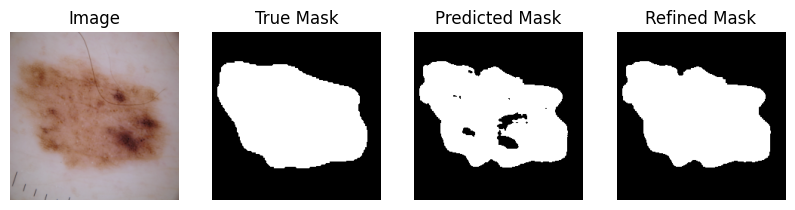

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BasicUNet().to(device)
model.load_state_dict(torch.load(r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/best_model_unet.pth"))

model.eval()
with torch.no_grad():
    img, true_mask = test_ds[0]
    input_tensor = img.unsqueeze(0).to(device)
    output = model(input_tensor)
    pred_mask = output[0,0].cpu().numpy()

# Threshold to binary
binary_mask = (pred_mask > 0.5).astype("uint8")

# --- Morphological refinement ---
filled_mask = ndi.binary_fill_holes(binary_mask)        # fill internal holes
clean_mask = ndi.binary_opening(filled_mask, structure=np.ones((3,3)))  # remove small noise
clean_mask = ndi.binary_closing(clean_mask, structure=np.ones((5,5)))   # close small gaps

refined_mask = clean_mask.astype("uint8")

plt.figure(figsize=(10,4))
plt.subplot(1,4,1); plt.imshow(img.permute(1,2,0)); plt.title("Image"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(true_mask.squeeze(), cmap="gray"); plt.title("True Mask"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(binary_mask, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(refined_mask, cmap="gray"); plt.title("Refined Mask"); plt.axis("off")
plt.show()

In [ ]:
def predict_scores_new(dataset):
    dice_scores = []
    iou_scores = []

    model.eval()
    with torch.no_grad():
        for img, true_mask in tqdm(dataset, desc="Evaluating"):
            # Move image to device
            input_tensor = img.unsqueeze(0).to(device)

            # Forward pass
            output = model(input_tensor)
            pred_mask = output[0, 0].cpu().numpy()

            # Binarize predictions and ground truth
            pred_bin = (pred_mask > 0.5).astype(np.uint8)
            true_bin = true_mask.squeeze().numpy().astype(np.uint8)

            # --- Morphological refinement ---
            filled_mask = ndi.binary_fill_holes(pred_bin)        # fill internal holes
            clean_mask = ndi.binary_opening(filled_mask, structure=np.ones((3,3)))  # remove small noise
            clean_mask = ndi.binary_closing(clean_mask, structure=np.ones((5,5)))   # close small gaps
            refined_mask = clean_mask.astype("uint8")

            # Compute metrics
            dice = dice_score(refined_mask, true_bin)
            iou = iou_score(refined_mask, true_bin)

            dice_scores.append(dice)
            iou_scores.append(iou)

    # --- PRINT RESULTS ---

    print(f"Mean Dice Score: {np.mean(dice_scores):.2f}")
    print(f"Mean IoU Score:  {np.mean(iou_scores):.2f}")


In [ ]:
print("TRAINING")
predict_scores_new(train_ds)
print("\nVALIDATION")
predict_scores_new(val_ds)
print("\nTEST")
predict_scores_new(test_ds)

TRAINING


Evaluating: 100%|██████████| 800/800 [01:20<00:00,  9.96it/s]


Mean Dice Score: 0.78
Mean IoU Score:  0.68

VALIDATION


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.41it/s]


Mean Dice Score: 0.78
Mean IoU Score:  0.68

TEST


Evaluating: 100%|██████████| 100/100 [00:09<00:00, 10.62it/s]

Mean Dice Score: 0.77
Mean IoU Score:  0.68


# MaNET

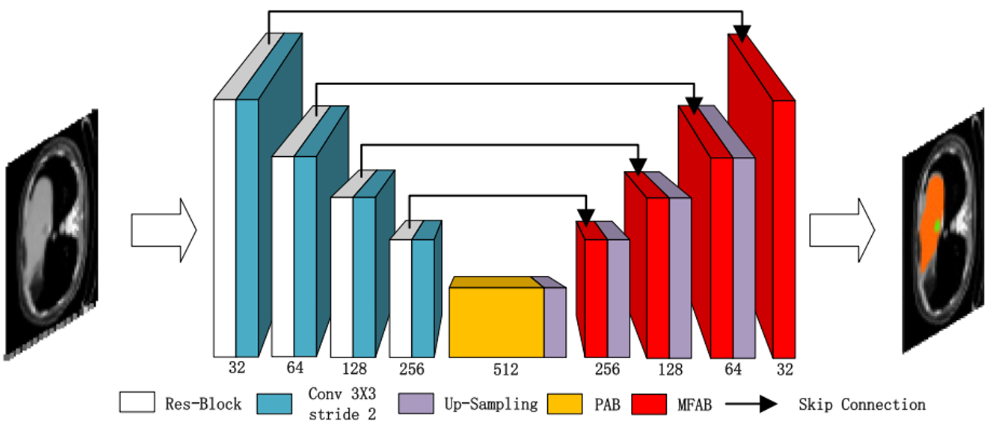

### Dataset

In [ ]:
image_dir = r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/dataset/ISIC_images"
mask_dir = r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/dataset/ISIC_masks"

# Check that each image has its correspondent mask
print('images:', len(os.listdir(image_dir)))
print('masks:', len(os.listdir(image_dir)))

images: 1000
masks: 1000


In [ ]:
all_images = sorted(glob(os.path.join(image_dir, '*')))
all_masks = sorted(glob(os.path.join(mask_dir, '*')))

# Get image base names (without extension)
image_names = [os.path.splitext(os.path.basename(p))[0] for p in all_images]

# Get mask base names and remove _segmentation suffix
mask_names = [os.path.splitext(os.path.basename(p))[0].replace('_segmentation','') for p in all_masks]

# Check for missing masks
missing_masks = [name for name in image_names if name not in mask_names]
missing_images = [name for name in mask_names if name not in image_names]

if not missing_masks and not missing_images:
    print("All images have corresponding masks!")
else:
    print(f'Missing masks for images: {missing_masks}')
    print(f'Missing images for masks: {missing_images}')

All images have corresponding masks!


In [ ]:
# Constants for image preprocessing
# ImageNet mean and std
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

# Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, img_size):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.img_size = img_size

        # Define transforms for image and mask (resize + to tensor)
        self.image_transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),  # converts to [0,1] float tensor
            transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize(img_size, interpolation=Image.NEAREST),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')  # grayscale

        img = self.image_transform(img)
        mask = self.mask_transform(mask)

        return img, mask

In [ ]:
# Create pairs of image + mask
pairs = [(i,m) for i,m in zip(all_images, all_masks)]
random.shuffle(pairs)

# Split into training, validation, and test sets
total = len(pairs)
train_end = int(0.8 * total)
val_end = int(0.9 * total)  # next 10% for validation, last 10% for test

train_pairs = pairs[:train_end]
val_pairs = pairs[train_end:val_end]
test_pairs = pairs[val_end:]

# Separate images and masks
train_imgs, train_masks = zip(*train_pairs)
val_imgs, val_masks = zip(*val_pairs)
test_imgs, test_masks = zip(*test_pairs)

# Define output image and mask size
img_size = (512, 512)

# Create datasets
train_ds = SegmentationDataset(train_imgs, train_masks, img_size=img_size)
val_ds = SegmentationDataset(val_imgs, val_masks, img_size=img_size)
test_ds = SegmentationDataset(test_imgs, test_masks, img_size=img_size)

# Create dataloaders
batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


# Check dimensions of one image and mask pair
img, mask = train_ds[0]
print(f"Image shape: {img.shape}")  # (C, H, W)
print(f"Mask shape: {mask.shape}")  # (1, H, W)

img, mask = val_ds[0]
print(f"\nImage shape: {img.shape}")   # (C, H, W)
print(f"Mask shape: {mask.shape}")   # (1, H, W)

img, mask = test_ds[0]
print(f"\nImage shape: {img.shape}")   # (C, H, W)
print(f"Mask shape: {mask.shape}")   # (1, H, W)

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([1, 512, 512])

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([1, 512, 512])

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([1, 512, 512])


In [ ]:
imgs, masks = next(iter(train_loader))
print(imgs.shape)  # should be (batch_size, C, H, W)
print(masks.shape) # should be (batch_size, C, H, W)


torch.Size([32, 3, 512, 512])
torch.Size([32, 1, 512, 512])


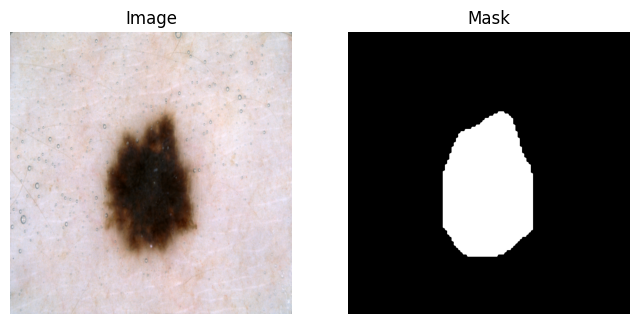

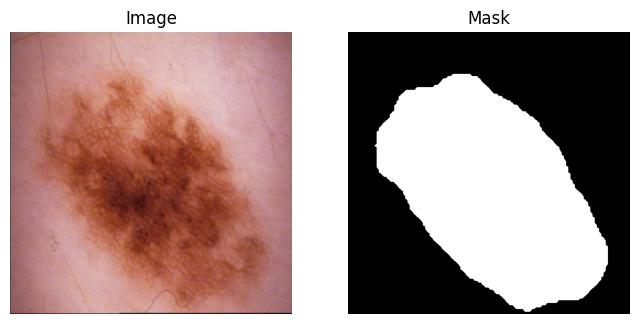

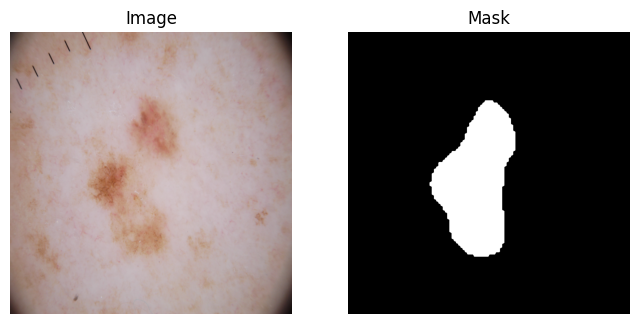

In [ ]:
import matplotlib.pyplot as plt

def show_examples(dataset, n=3):
    for i in range(n):
        img, mask = dataset[i]
        for c in range(3):
            img[c] = img[c] * IMG_STD[c] + IMG_MEAN[c]

        img_np = img.permute(1, 2, 0).numpy()  # (C,H,W) -> (H,W,C)
        mask_np = mask.squeeze(0).numpy()      # (1,H,W) -> (H,W)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(img_np)
        ax[0].set_title("Image")
        ax[0].axis('off')

        ax[1].imshow(mask_np, cmap='gray')
        ax[1].set_title("Mask")
        ax[1].axis('off')

        plt.show()

# Show 3 examples from the training dataset
show_examples(test_ds, n=3)


### Model definition

In [ ]:
import segmentation_models_pytorch as smp

# Binary segmentation -> classes=1
model = smp.MAnet(
    encoder_name="mit_b0",       # small transformer backbone
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

### Model training

In [ ]:
# --- Model initialization ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- Scheduler & Early stopping ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
patience = 10
best_val_loss = float("inf")
epochs_no_improve = 0

# --- Training loop ---
n_epochs = 100
train_losses, val_losses = [], []
train_dices, val_dices = [], []

for epoch in range(n_epochs):
    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0.0
    train_dice = 0.0
    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch [{epoch+1}/{n_epochs}]")

    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coefficient(outputs, masks)

        loop.set_postfix(loss=loss.item(), dice=dice_coefficient(outputs, masks))

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)
    train_losses.append(train_loss)
    train_dices.append(train_dice)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_dice += dice_coefficient(outputs, masks)

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_losses.append(val_loss)
    val_dices.append(val_dice)

    scheduler.step(val_loss)

    print(f"\nEpoch [{epoch+1}/{n_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

    # ---------------- EARLY STOPPING ----------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model_manet.pth")
        print("💾 Saved new best model.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("🛑 Early stopping triggered!")
        break


cuda


Epoch [1/100]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/100]: 100%|██████████| 25/25 [04:19<00:00, 10.38s/it, dice=0.814, loss=0.345]



Epoch [1/100] | Train Loss: 0.5073 | Train Dice: 0.5534 | Val Loss: 0.4862 | Val Dice: 0.7465
💾 Saved new best model.


Epoch [2/100]: 100%|██████████| 25/25 [03:57<00:00,  9.51s/it, dice=0.826, loss=0.304]



Epoch [2/100] | Train Loss: 0.3102 | Train Dice: 0.8368 | Val Loss: 0.2802 | Val Dice: 0.8516
💾 Saved new best model.


Epoch [3/100]: 100%|██████████| 25/25 [04:01<00:00,  9.65s/it, dice=0.848, loss=0.257]



Epoch [3/100] | Train Loss: 0.2569 | Train Dice: 0.8608 | Val Loss: 0.3042 | Val Dice: 0.8430
No improvement for 1 epoch(s).


Epoch [4/100]: 100%|██████████| 25/25 [04:15<00:00, 10.23s/it, dice=0.869, loss=0.225]



Epoch [4/100] | Train Loss: 0.2317 | Train Dice: 0.8623 | Val Loss: 0.2329 | Val Dice: 0.8493
💾 Saved new best model.


Epoch [5/100]: 100%|██████████| 25/25 [04:29<00:00, 10.78s/it, dice=0.888, loss=0.192]



Epoch [5/100] | Train Loss: 0.2012 | Train Dice: 0.8869 | Val Loss: 0.3331 | Val Dice: 0.8361
No improvement for 1 epoch(s).


Epoch [6/100]: 100%|██████████| 25/25 [04:38<00:00, 11.13s/it, dice=0.832, loss=0.277]



Epoch [6/100] | Train Loss: 0.1920 | Train Dice: 0.8823 | Val Loss: 0.2570 | Val Dice: 0.8527
No improvement for 2 epoch(s).


Epoch [7/100]: 100%|██████████| 25/25 [04:32<00:00, 10.92s/it, dice=0.898, loss=0.17] 



Epoch [7/100] | Train Loss: 0.1763 | Train Dice: 0.8937 | Val Loss: 0.2918 | Val Dice: 0.8420
No improvement for 3 epoch(s).


Epoch [8/100]: 100%|██████████| 25/25 [04:26<00:00, 10.66s/it, dice=0.906, loss=0.171]



Epoch [8/100] | Train Loss: 0.1602 | Train Dice: 0.8999 | Val Loss: 0.2124 | Val Dice: 0.8722
💾 Saved new best model.


Epoch [9/100]: 100%|██████████| 25/25 [04:22<00:00, 10.52s/it, dice=0.873, loss=0.148]



Epoch [9/100] | Train Loss: 0.1516 | Train Dice: 0.9054 | Val Loss: 0.2030 | Val Dice: 0.8557
💾 Saved new best model.


Epoch [10/100]: 100%|██████████| 25/25 [04:22<00:00, 10.49s/it, dice=0.915, loss=0.188]



Epoch [10/100] | Train Loss: 0.1405 | Train Dice: 0.9053 | Val Loss: 0.1821 | Val Dice: 0.8811
💾 Saved new best model.


Epoch [11/100]: 100%|██████████| 25/25 [04:32<00:00, 10.89s/it, dice=0.885, loss=0.183]



Epoch [11/100] | Train Loss: 0.1350 | Train Dice: 0.9115 | Val Loss: 0.2211 | Val Dice: 0.8395
No improvement for 1 epoch(s).


Epoch [12/100]: 100%|██████████| 25/25 [04:29<00:00, 10.79s/it, dice=0.93, loss=0.107] 



Epoch [12/100] | Train Loss: 0.1294 | Train Dice: 0.9110 | Val Loss: 0.2049 | Val Dice: 0.8594
No improvement for 2 epoch(s).


Epoch [13/100]: 100%|██████████| 25/25 [04:06<00:00,  9.85s/it, dice=0.931, loss=0.151] 



Epoch [13/100] | Train Loss: 0.1200 | Train Dice: 0.9215 | Val Loss: 0.3181 | Val Dice: 0.8414
No improvement for 3 epoch(s).


Epoch [14/100]: 100%|██████████| 25/25 [02:16<00:00,  5.45s/it, dice=0.914, loss=0.124] 



Epoch [14/100] | Train Loss: 0.1161 | Train Dice: 0.9199 | Val Loss: 0.2097 | Val Dice: 0.8429
No improvement for 4 epoch(s).


Epoch [15/100]: 100%|██████████| 25/25 [02:15<00:00,  5.43s/it, dice=0.895, loss=0.154] 



Epoch [15/100] | Train Loss: 0.1145 | Train Dice: 0.9161 | Val Loss: 0.2432 | Val Dice: 0.8596
No improvement for 5 epoch(s).


Epoch [16/100]: 100%|██████████| 25/25 [02:14<00:00,  5.37s/it, dice=0.938, loss=0.108] 



Epoch [16/100] | Train Loss: 0.1126 | Train Dice: 0.9183 | Val Loss: 0.1853 | Val Dice: 0.8756
No improvement for 6 epoch(s).


Epoch [17/100]: 100%|██████████| 25/25 [02:19<00:00,  5.57s/it, dice=0.942, loss=0.103] 



Epoch [17/100] | Train Loss: 0.0998 | Train Dice: 0.9322 | Val Loss: 0.2072 | Val Dice: 0.8649
No improvement for 7 epoch(s).


Epoch [18/100]: 100%|██████████| 25/25 [02:24<00:00,  5.77s/it, dice=0.934, loss=0.0962]



Epoch [18/100] | Train Loss: 0.0944 | Train Dice: 0.9331 | Val Loss: 0.1982 | Val Dice: 0.8618
No improvement for 8 epoch(s).


Epoch [19/100]: 100%|██████████| 25/25 [02:22<00:00,  5.70s/it, dice=0.944, loss=0.0809]



Epoch [19/100] | Train Loss: 0.0926 | Train Dice: 0.9317 | Val Loss: 0.1948 | Val Dice: 0.8671
No improvement for 9 epoch(s).


Epoch [20/100]: 100%|██████████| 25/25 [02:19<00:00,  5.59s/it, dice=0.939, loss=0.0762]



Epoch [20/100] | Train Loss: 0.0859 | Train Dice: 0.9407 | Val Loss: 0.2083 | Val Dice: 0.8538
No improvement for 10 epoch(s).
🛑 Early stopping triggered!


### Model evaluation

cuda


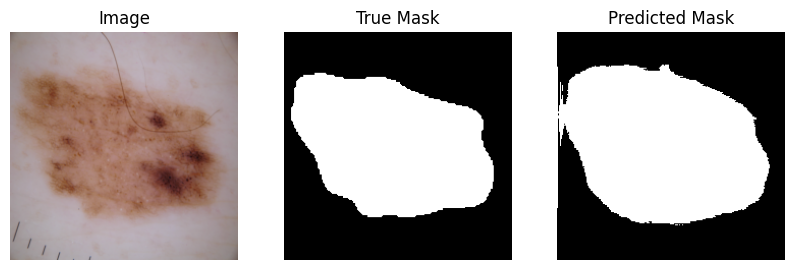

In [ ]:
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = smp.MAnet(
    encoder_name="mit_b0",
    encoder_weights=None,
    in_channels=3,
    classes=1
)
model = model.to(device)
model.load_state_dict(torch.load(r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/best_model_manet.pth"))

model.eval()
with torch.no_grad():
    img, true_mask = test_ds[0]
    input_tensor = img.unsqueeze(0).to(device)
    output = model(input_tensor)
    pred_mask = torch.sigmoid(output[0,0]).cpu().numpy()

# Threshold to binary
binary_mask = (pred_mask > 0.5).astype("uint8")

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img.permute(1,2,0)); plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(true_mask.squeeze(), cmap="gray"); plt.title("True Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(binary_mask, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
plt.show()


In [ ]:
def predict_scores(dataset):
    dice_scores = []
    iou_scores = []

    model.eval()
    with torch.no_grad():
        for img, true_mask in tqdm(dataset, desc="Evaluating"):
            # Move image to device
            input_tensor = img.unsqueeze(0).to(device)

            # Forward pass
            output = model(input_tensor)
            pred_mask = torch.sigmoid(output)[0, 0].cpu().numpy()

            # Binarize predictions and ground truth
            pred_bin = (pred_mask > 0.5).astype(np.uint8)
            true_bin = true_mask.squeeze().numpy().astype(np.uint8)

            # Compute metrics
            dice = dice_score(pred_bin, true_bin)
            iou = iou_score(pred_bin, true_bin)

            dice_scores.append(dice)
            iou_scores.append(iou)

    # --- PRINT RESULTS ---

    print(f"Mean Dice Score: {np.mean(dice_scores):.2f}")
    print(f"Mean IoU Score:  {np.mean(iou_scores):.2f}")

In [ ]:
print("TRAINING")
predict_scores(train_ds)
print("\nVALIDATION")
predict_scores(val_ds)
print("\nTEST")
predict_scores(test_ds)

TRAINING


Evaluating: 100%|██████████| 800/800 [01:21<00:00,  9.77it/s]


Mean Dice Score: 0.8166
Mean IoU Score:  0.7303

VALIDATION


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


Mean Dice Score: 0.8157
Mean IoU Score:  0.7244

TEST


Evaluating: 100%|██████████| 100/100 [00:10<00:00,  9.69it/s]

Mean Dice Score: 0.8131
Mean IoU Score:  0.7240


cuda


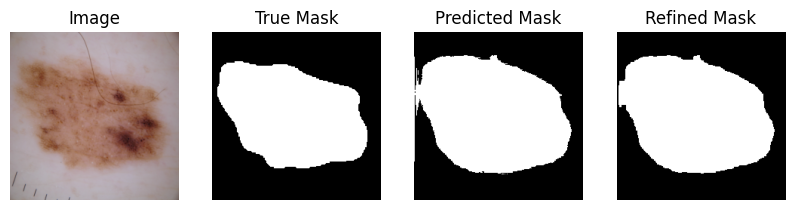

In [ ]:
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = smp.MAnet(
    encoder_name="mit_b0",
    encoder_weights=None,
    in_channels=3,
    classes=1
)
model = model.to(device)
model.load_state_dict(torch.load(r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/best_model_manet.pth"))

model.eval()
with torch.no_grad():
    img, true_mask = test_ds[0]
    input_tensor = img.unsqueeze(0).to(device)
    output = model(input_tensor)
    pred_mask = torch.sigmoid(output[0,0]).cpu().numpy()

# Threshold to binary
binary_mask = (pred_mask > 0.5).astype("uint8")

# --- Morphological refinement ---
filled_mask = ndi.binary_fill_holes(binary_mask)        # fill internal holes
clean_mask = ndi.binary_opening(filled_mask, structure=np.ones((3,3)))  # remove small noise
clean_mask = ndi.binary_closing(clean_mask, structure=np.ones((5,5)))   # close small gaps

refined_mask = clean_mask.astype("uint8")

plt.figure(figsize=(10,4))
plt.subplot(1,4,1); plt.imshow(img.permute(1,2,0)); plt.title("Image"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(true_mask.squeeze(), cmap="gray"); plt.title("True Mask"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(binary_mask, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(refined_mask, cmap="gray"); plt.title("Refined Mask"); plt.axis("off")
plt.show()

In [ ]:
def predict_scores_new(dataset):
    dice_scores = []
    iou_scores = []

    model.eval()
    with torch.no_grad():
        for img, true_mask in tqdm(dataset, desc="Evaluating"):
            # Move image to device
            input_tensor = img.unsqueeze(0).to(device)

            # Forward pass
            output = model(input_tensor)
            pred_mask = torch.sigmoid(output)[0, 0].cpu().numpy()

            # Binarize predictions and ground truth
            pred_bin = (pred_mask > 0.5).astype(np.uint8)
            true_bin = true_mask.squeeze().numpy().astype(np.uint8)

            # --- Morphological refinement ---
            filled_mask = ndi.binary_fill_holes(pred_bin)        # fill internal holes
            clean_mask = ndi.binary_opening(filled_mask, structure=np.ones((3,3)))  # remove small noise
            clean_mask = ndi.binary_closing(clean_mask, structure=np.ones((5,5)))   # close small gaps
            refined_mask = clean_mask.astype("uint8")

            # Compute metrics
            dice = dice_score(refined_mask, true_bin)
            iou = iou_score(refined_mask, true_bin)

            dice_scores.append(dice)
            iou_scores.append(iou)

    # --- PRINT RESULTS ---

    print(f"Mean Dice Score: {np.mean(dice_scores):.2f}")
    print(f"Mean IoU Score:  {np.mean(iou_scores):.2f}")

In [ ]:
print("TRAINING")
predict_scores_new(train_ds)
print("\nVALIDATION")
predict_scores_new(val_ds)
print("\nTEST")
predict_scores_new(test_ds)

TRAINING


Evaluating: 100%|██████████| 800/800 [01:25<00:00,  9.32it/s]


Mean Dice Score: 0.8165
Mean IoU Score:  0.7301

VALIDATION


Evaluating: 100%|██████████| 100/100 [00:09<00:00, 10.69it/s]


Mean Dice Score: 0.8149
Mean IoU Score:  0.7234

TEST


Evaluating: 100%|██████████| 100/100 [00:10<00:00,  9.88it/s]

Mean Dice Score: 0.8130
Mean IoU Score:  0.7239


# DeepLabV3
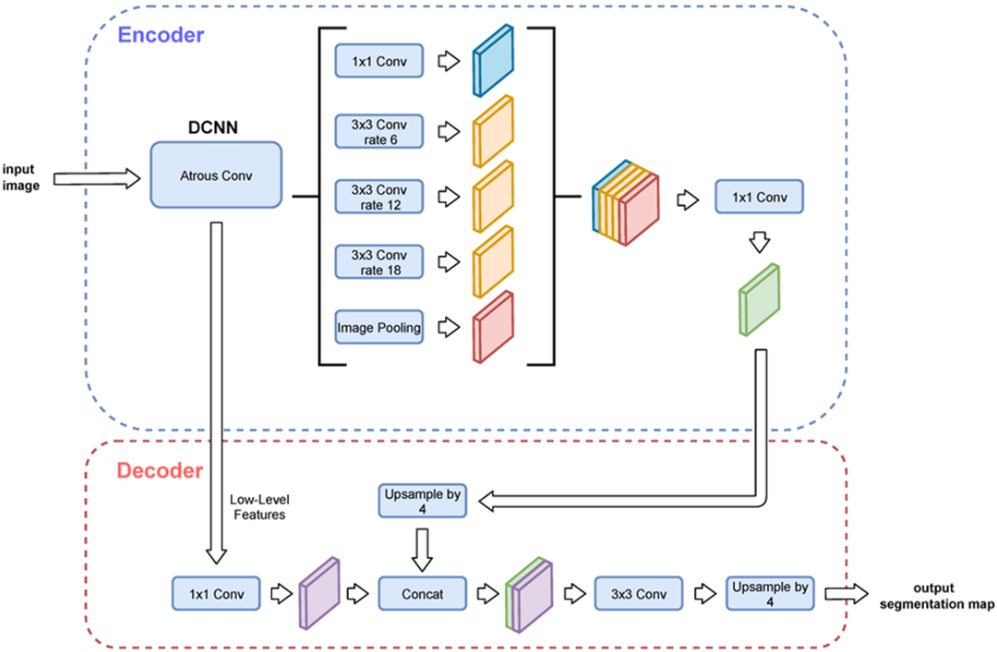

### Dataset

In [ ]:
image_dir = r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/dataset/ISIC_images"
mask_dir = r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/dataset/ISIC_masks"

# Check that each image has its correspondent mask
print('images:', len(os.listdir(image_dir)))
print('masks:', len(os.listdir(image_dir)))

images: 1000
masks: 1000


In [ ]:
all_images = sorted(glob(os.path.join(image_dir, '*')))
all_masks = sorted(glob(os.path.join(mask_dir, '*')))

# Get image base names (without extension)
image_names = [os.path.splitext(os.path.basename(p))[0] for p in all_images]

# Get mask base names and remove _segmentation suffix
mask_names = [os.path.splitext(os.path.basename(p))[0].replace('_segmentation','') for p in all_masks]

# Check for missing masks
missing_masks = [name for name in image_names if name not in mask_names]
missing_images = [name for name in mask_names if name not in image_names]

if not missing_masks and not missing_images:
    print("All images have corresponding masks!")
else:
    print(f'Missing masks for images: {missing_masks}')
    print(f'Missing images for masks: {missing_images}')

All images have corresponding masks!


In [ ]:
# Constants for image preprocessing
# ImageNet mean and std
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

# Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, img_size):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.img_size = img_size

        # Define transforms for image and mask (resize + to tensor)
        self.image_transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),  # converts to [0,1] float tensor
            transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize(img_size, interpolation=Image.NEAREST),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')  # grayscale

        img = self.image_transform(img)
        mask = self.mask_transform(mask)

        return img, mask

In [ ]:
# Create pairs of image + mask
pairs = [(i,m) for i,m in zip(all_images, all_masks)]
random.shuffle(pairs)

# Split into training, validation, and test sets
total = len(pairs)
train_end = int(0.8 * total)
val_end = int(0.9 * total)  # next 10% for validation, last 10% for test

train_pairs = pairs[:train_end]
val_pairs = pairs[train_end:val_end]
test_pairs = pairs[val_end:]

# Separate images and masks
train_imgs, train_masks = zip(*train_pairs)
val_imgs, val_masks = zip(*val_pairs)
test_imgs, test_masks = zip(*test_pairs)

# Define output image and mask size
img_size = (224, 224)

# Create datasets
train_ds = SegmentationDataset(train_imgs, train_masks, img_size=img_size)
val_ds = SegmentationDataset(val_imgs, val_masks, img_size=img_size)
test_ds = SegmentationDataset(test_imgs, test_masks, img_size=img_size)

# Create dataloaders
batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


# Check dimensions of one image and mask pair
img, mask = train_ds[0]
print(f"Image shape: {img.shape}")  # (C, H, W)
print(f"Mask shape: {mask.shape}")  # (1, H, W)

img, mask = val_ds[0]
print(f"\nImage shape: {img.shape}")   # (C, H, W)
print(f"Mask shape: {mask.shape}")   # (1, H, W)

img, mask = test_ds[0]
print(f"\nImage shape: {img.shape}")   # (C, H, W)
print(f"Mask shape: {mask.shape}")   # (1, H, W)

Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([1, 224, 224])

Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([1, 224, 224])

Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([1, 224, 224])


In [ ]:
imgs, masks = next(iter(train_loader))
print(imgs.shape)  # should be (batch_size, C, H, W)
print(masks.shape) # should be (batch_size, C, H, W)


torch.Size([32, 3, 224, 224])
torch.Size([32, 1, 224, 224])


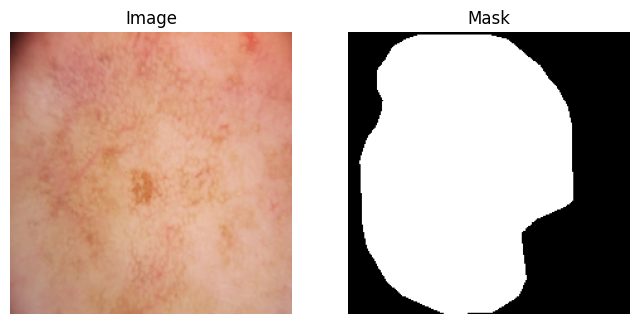

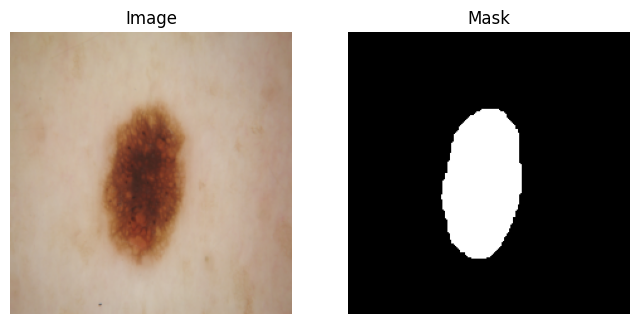

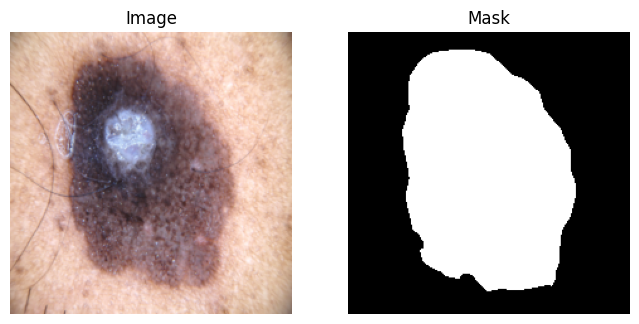

In [ ]:
import matplotlib.pyplot as plt

def show_examples(dataset, n=3):
    for i in range(n):
        img, mask = dataset[i]
        for c in range(3):
            img[c] = img[c] * IMG_STD[c] + IMG_MEAN[c]

        img_np = img.permute(1, 2, 0).numpy()  # (C,H,W) -> (H,W,C)
        mask_np = mask.squeeze(0).numpy()      # (1,H,W) -> (H,W)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(img_np)
        ax[0].set_title("Image")
        ax[0].axis('off')

        ax[1].imshow(mask_np, cmap='gray')
        ax[1].set_title("Mask")
        ax[1].axis('off')

        plt.show()

# Show 3 examples from the training dataset
show_examples(test_ds, n=3)


### Model definition

In [ ]:
# Load pretrained DeepLabV3 pre-trained on COCO dataset
model = models.segmentation.deeplabv3_resnet101(weights="COCO_WITH_VOC_LABELS_V1")

# Adjust the classifier head for your number of classes, e.g., binary (1 class) or multi-class segmentation
NUM_CLASSES = 1 # lesion vs. background
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### Model training

In [ ]:
# --- Model initialization ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- Scheduler & Early stopping ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
patience = 10
best_val_loss = float("inf")
epochs_no_improve = 0

# --- Training loop ---
n_epochs = 100
train_losses, val_losses = [], []
train_dices, val_dices = [], []

for epoch in range(n_epochs):
    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0.0
    train_dice = 0.0
    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch [{epoch+1}/{n_epochs}]")

    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)["out"]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coefficient(outputs, masks)

        loop.set_postfix(loss=loss.item(), dice=dice_coefficient(outputs, masks))

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)
    train_losses.append(train_loss)
    train_dices.append(train_dice)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)["out"]
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_dice += dice_coefficient(outputs, masks)

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_losses.append(val_loss)
    val_dices.append(val_dice)

    scheduler.step(val_loss)

    print(f"\nEpoch [{epoch+1}/{n_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

    # ---------------- EARLY STOPPING ----------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model_deeplabv3.pth")
        print("💾 Saved new best model.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("🛑 Early stopping triggered!")
        break


cuda


Epoch [1/100]: 100%|██████████| 25/25 [02:43<00:00,  6.53s/it, dice=0.889, loss=0.268]  



Epoch [1/100] | Train Loss: 0.4070 | Train Dice: 0.7205 | Val Loss: 0.2329 | Val Dice: 0.8864
💾 Saved new best model.


Epoch [2/100]: 100%|██████████| 25/25 [02:41<00:00,  6.48s/it, dice=0.908, loss=0.217]



Epoch [2/100] | Train Loss: 0.2161 | Train Dice: 0.8991 | Val Loss: 0.2095 | Val Dice: 0.8880
💾 Saved new best model.


Epoch [3/100]: 100%|██████████| 25/25 [02:44<00:00,  6.57s/it, dice=0.903, loss=0.17] 



Epoch [3/100] | Train Loss: 0.1828 | Train Dice: 0.9143 | Val Loss: 0.1902 | Val Dice: 0.9100
💾 Saved new best model.


Epoch [4/100]: 100%|██████████| 25/25 [02:43<00:00,  6.54s/it, dice=0.934, loss=0.166]



Epoch [4/100] | Train Loss: 0.1569 | Train Dice: 0.9273 | Val Loss: 0.1867 | Val Dice: 0.8948
💾 Saved new best model.


Epoch [5/100]: 100%|██████████| 25/25 [02:44<00:00,  6.59s/it, dice=0.938, loss=0.132]



Epoch [5/100] | Train Loss: 0.1390 | Train Dice: 0.9326 | Val Loss: 0.1821 | Val Dice: 0.9091
💾 Saved new best model.


Epoch [6/100]: 100%|██████████| 25/25 [02:45<00:00,  6.64s/it, dice=0.922, loss=0.128]



Epoch [6/100] | Train Loss: 0.1231 | Train Dice: 0.9376 | Val Loss: 0.1764 | Val Dice: 0.9124
💾 Saved new best model.


Epoch [7/100]: 100%|██████████| 25/25 [02:44<00:00,  6.58s/it, dice=0.938, loss=0.107] 



Epoch [7/100] | Train Loss: 0.1114 | Train Dice: 0.9475 | Val Loss: 0.1754 | Val Dice: 0.8998
💾 Saved new best model.


Epoch [8/100]: 100%|██████████| 25/25 [02:46<00:00,  6.67s/it, dice=0.94, loss=0.0933] 



Epoch [8/100] | Train Loss: 0.1002 | Train Dice: 0.9494 | Val Loss: 0.1718 | Val Dice: 0.9053
💾 Saved new best model.


Epoch [9/100]: 100%|██████████| 25/25 [02:45<00:00,  6.64s/it, dice=0.964, loss=0.09]  



Epoch [9/100] | Train Loss: 0.0918 | Train Dice: 0.9528 | Val Loss: 0.1689 | Val Dice: 0.9061
💾 Saved new best model.


Epoch [10/100]: 100%|██████████| 25/25 [02:45<00:00,  6.62s/it, dice=0.961, loss=0.0762]



Epoch [10/100] | Train Loss: 0.0825 | Train Dice: 0.9580 | Val Loss: 0.1612 | Val Dice: 0.9098
💾 Saved new best model.


Epoch [11/100]: 100%|██████████| 25/25 [02:45<00:00,  6.62s/it, dice=0.962, loss=0.0741]



Epoch [11/100] | Train Loss: 0.0755 | Train Dice: 0.9613 | Val Loss: 0.1607 | Val Dice: 0.9140
💾 Saved new best model.


Epoch [12/100]: 100%|██████████| 25/25 [02:43<00:00,  6.55s/it, dice=0.97, loss=0.075]  



Epoch [12/100] | Train Loss: 0.0708 | Train Dice: 0.9656 | Val Loss: 0.1581 | Val Dice: 0.9134
💾 Saved new best model.


Epoch [13/100]: 100%|██████████| 25/25 [02:46<00:00,  6.64s/it, dice=0.973, loss=0.0548]



Epoch [13/100] | Train Loss: 0.0663 | Train Dice: 0.9666 | Val Loss: 0.1579 | Val Dice: 0.9132
💾 Saved new best model.


Epoch [14/100]: 100%|██████████| 25/25 [02:47<00:00,  6.69s/it, dice=0.975, loss=0.055] 



Epoch [14/100] | Train Loss: 0.0600 | Train Dice: 0.9692 | Val Loss: 0.1602 | Val Dice: 0.9131
No improvement for 1 epoch(s).


Epoch [15/100]: 100%|██████████| 25/25 [02:43<00:00,  6.55s/it, dice=0.968, loss=0.0595]



Epoch [15/100] | Train Loss: 0.0567 | Train Dice: 0.9711 | Val Loss: 0.1589 | Val Dice: 0.9121
No improvement for 2 epoch(s).


Epoch [16/100]: 100%|██████████| 25/25 [02:43<00:00,  6.56s/it, dice=0.968, loss=0.0496]



Epoch [16/100] | Train Loss: 0.0531 | Train Dice: 0.9715 | Val Loss: 0.1593 | Val Dice: 0.9098
No improvement for 3 epoch(s).


Epoch [17/100]: 100%|██████████| 25/25 [02:47<00:00,  6.68s/it, dice=0.978, loss=0.0451]



Epoch [17/100] | Train Loss: 0.0497 | Train Dice: 0.9736 | Val Loss: 0.1640 | Val Dice: 0.9102
No improvement for 4 epoch(s).


Epoch [18/100]: 100%|██████████| 25/25 [02:46<00:00,  6.64s/it, dice=0.971, loss=0.0449]



Epoch [18/100] | Train Loss: 0.0473 | Train Dice: 0.9751 | Val Loss: 0.1692 | Val Dice: 0.9068
No improvement for 5 epoch(s).


Epoch [19/100]: 100%|██████████| 25/25 [02:45<00:00,  6.64s/it, dice=0.977, loss=0.0426]



Epoch [19/100] | Train Loss: 0.0442 | Train Dice: 0.9747 | Val Loss: 0.1702 | Val Dice: 0.9082
No improvement for 6 epoch(s).


Epoch [20/100]: 100%|██████████| 25/25 [02:44<00:00,  6.57s/it, dice=0.969, loss=0.0398]



Epoch [20/100] | Train Loss: 0.0420 | Train Dice: 0.9770 | Val Loss: 0.1647 | Val Dice: 0.9099
No improvement for 7 epoch(s).


Epoch [21/100]: 100%|██████████| 25/25 [02:46<00:00,  6.64s/it, dice=0.978, loss=0.0404]



Epoch [21/100] | Train Loss: 0.0404 | Train Dice: 0.9780 | Val Loss: 0.1631 | Val Dice: 0.9121
No improvement for 8 epoch(s).


Epoch [22/100]: 100%|██████████| 25/25 [02:43<00:00,  6.54s/it, dice=0.985, loss=0.0368]



Epoch [22/100] | Train Loss: 0.0394 | Train Dice: 0.9786 | Val Loss: 0.1648 | Val Dice: 0.9125
No improvement for 9 epoch(s).


Epoch [23/100]: 100%|██████████| 25/25 [02:43<00:00,  6.54s/it, dice=0.983, loss=0.0362]



Epoch [23/100] | Train Loss: 0.0379 | Train Dice: 0.9792 | Val Loss: 0.1666 | Val Dice: 0.9120
No improvement for 10 epoch(s).
🛑 Early stopping triggered!


### Model evaluation

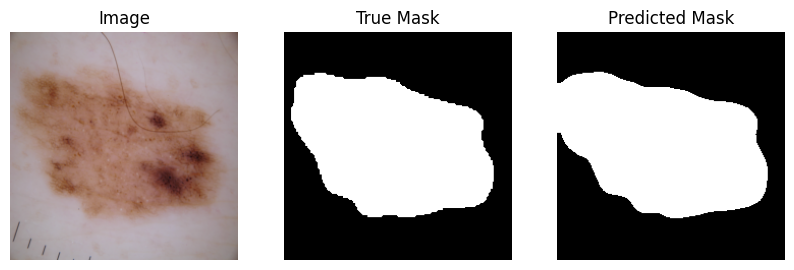

In [ ]:
# Load pretrained DeepLabV3 pre-trained on COCO dataset
model = models.segmentation.deeplabv3_resnet101(weights="COCO_WITH_VOC_LABELS_V1")

# Adjust the classifier head for your number of classes, e.g., binary (1 class) or multi-class segmentation
NUM_CLASSES = 1 # lesion vs. background
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model = model.to(device)
model.load_state_dict(torch.load(r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/best_model_deeplabv3.pth"))

model.eval()
with torch.no_grad():
    img, true_mask = test_ds[0]
    input_tensor = img.unsqueeze(0).to(device)
    output = model(input_tensor)["out"]
    pred_mask = torch.sigmoid(output[0]).cpu().numpy().squeeze()

# Threshold to binary
binary_mask = (pred_mask > 0.5).astype("uint8")

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img.permute(1,2,0)); plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(true_mask.squeeze(), cmap="gray"); plt.title("True Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(binary_mask, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
plt.show()


In [ ]:
def predict_scores(dataset):
    dice_scores = []
    iou_scores = []

    model.eval()
    with torch.no_grad():
        for img, true_mask in tqdm(dataset, desc="Evaluating"):
            # Move image to device
            input_tensor = img.unsqueeze(0).to(device)

            # Forward pass
            output = model(input_tensor)["out"]
            pred_mask = torch.sigmoid(output)[0].cpu().numpy().squeeze()

            # Binarize predictions and ground truth
            pred_bin = (pred_mask > 0.5).astype(np.uint8)
            true_bin = true_mask.squeeze().numpy().astype(np.uint8)

            # Compute metrics
            dice = dice_score(pred_bin, true_bin)
            iou = iou_score(pred_bin, true_bin)

            dice_scores.append(dice)
            iou_scores.append(iou)

    # --- PRINT RESULTS ---

    print(f"Mean Dice Score: {np.mean(dice_scores):.2f}")
    print(f"Mean IoU Score:  {np.mean(iou_scores):.2f}")

In [ ]:
print("TRAINING")
predict_scores(train_ds)
print("\nVALIDATION")
predict_scores(val_ds)
print("\nTEST")
predict_scores(test_ds)

TRAINING


Evaluating: 100%|██████████| 800/800 [01:17<00:00, 10.34it/s]


Mean Dice Score: 0.84
Mean IoU Score:  0.77

VALIDATION


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.30it/s]


Mean Dice Score: 0.85
Mean IoU Score:  0.78

TEST


Evaluating: 100%|██████████| 100/100 [00:09<00:00, 10.32it/s]

Mean Dice Score: 0.87
Mean IoU Score:  0.80


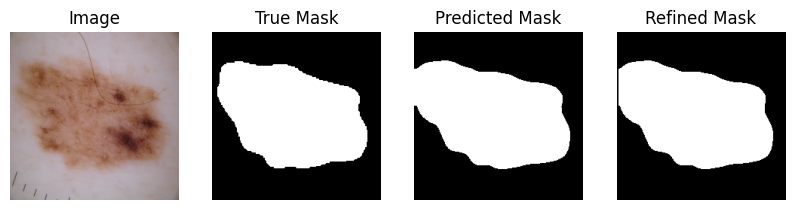

In [ ]:
# Load pretrained DeepLabV3 pre-trained on COCO dataset
model = models.segmentation.deeplabv3_resnet101(weights="COCO_WITH_VOC_LABELS_V1")

# Adjust the classifier head for your number of classes, e.g., binary (1 class) or multi-class segmentation
NUM_CLASSES = 1 # lesion vs. background
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model = model.to(device)
model.load_state_dict(torch.load(r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/best_model_deeplabv3.pth"))

model.eval()
with torch.no_grad():
    img, true_mask = test_ds[0]
    input_tensor = img.unsqueeze(0).to(device)
    output = model(input_tensor)["out"]
    pred_mask = torch.sigmoid(output[0]).cpu().numpy().squeeze()

# Threshold to binary
binary_mask = (pred_mask > 0.5).astype("uint8")

# --- Morphological refinement ---
filled_mask = ndi.binary_fill_holes(binary_mask)        # fill internal holes
clean_mask = ndi.binary_opening(filled_mask, structure=np.ones((3,3)))  # remove small noise
clean_mask = ndi.binary_closing(clean_mask, structure=np.ones((5,5)))   # close small gaps

refined_mask = clean_mask.astype("uint8")

plt.figure(figsize=(10,4))
plt.subplot(1,4,1); plt.imshow(img.permute(1,2,0)); plt.title("Image"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(true_mask.squeeze(), cmap="gray"); plt.title("True Mask"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(binary_mask, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(refined_mask, cmap="gray"); plt.title("Refined Mask"); plt.axis("off")
plt.show()


In [ ]:
def predict_scores_new(dataset):
    dice_scores = []
    iou_scores = []

    model.eval()
    with torch.no_grad():
        for img, true_mask in tqdm(dataset, desc="Evaluating"):
            # Move image to device
            input_tensor = img.unsqueeze(0).to(device)

            # Forward pass
            output = model(input_tensor)["out"]
            pred_mask = torch.sigmoid(output)[0].cpu().numpy().squeeze()

            # Binarize predictions and ground truth
            pred_bin = (pred_mask > 0.5).astype(np.uint8)
            true_bin = true_mask.squeeze().numpy().astype(np.uint8)

            # --- Morphological refinement ---
            filled_mask = ndi.binary_fill_holes(pred_bin)        # fill internal holes
            clean_mask = ndi.binary_opening(filled_mask, structure=np.ones((3,3)))  # remove small noise
            clean_mask = ndi.binary_closing(clean_mask, structure=np.ones((5,5)))   # close small gaps
            refined_mask = clean_mask.astype("uint8")

            # Compute metrics
            dice = dice_score(refined_mask, true_bin)
            iou = iou_score(refined_mask, true_bin)

            dice_scores.append(dice)
            iou_scores.append(iou)

    # --- PRINT RESULTS ---

    print(f"Mean Dice Score: {np.mean(dice_scores):.2f}")
    print(f"Mean IoU Score:  {np.mean(iou_scores):.2f}")

In [ ]:
print("TRAINING")
predict_scores_new(train_ds)
print("\nVALIDATION")
predict_scores_new(val_ds)
print("\nTEST")
predict_scores_new(test_ds)

TRAINING


Evaluating: 100%|██████████| 800/800 [01:22<00:00,  9.72it/s]


Mean Dice Score: 0.84
Mean IoU Score:  0.77

VALIDATION


Evaluating: 100%|██████████| 100/100 [00:09<00:00, 10.41it/s]


Mean Dice Score: 0.85
Mean IoU Score:  0.78

TEST


Evaluating: 100%|██████████| 100/100 [00:10<00:00,  9.23it/s]

Mean Dice Score: 0.87
Mean IoU Score:  0.80


# SegFormer
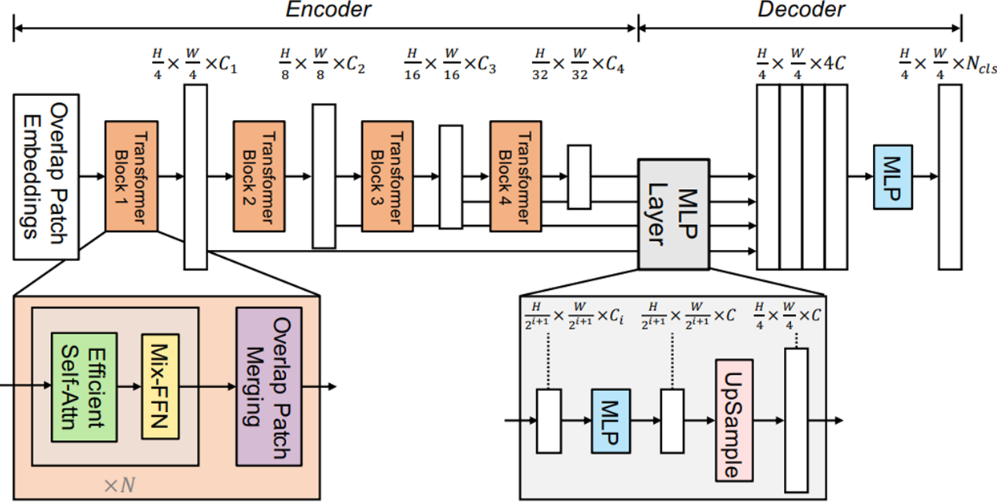

### Dataset

In [ ]:
image_dir = r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/dataset/ISIC_images"
mask_dir = r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/dataset/ISIC_masks"

# Check that each image has its correspondent mask
print('images:', len(os.listdir(image_dir)))
print('masks:', len(os.listdir(image_dir)))

images: 1000
masks: 1000


In [ ]:
all_images = sorted(glob(os.path.join(image_dir, '*')))
all_masks = sorted(glob(os.path.join(mask_dir, '*')))

# Get image base names (without extension)
image_names = [os.path.splitext(os.path.basename(p))[0] for p in all_images]

# Get mask base names and remove _segmentation suffix
mask_names = [os.path.splitext(os.path.basename(p))[0].replace('_segmentation','') for p in all_masks]

# Check for missing masks
missing_masks = [name for name in image_names if name not in mask_names]
missing_images = [name for name in mask_names if name not in image_names]

if not missing_masks and not missing_images:
    print("All images have corresponding masks!")
else:
    print(f'Missing masks for images: {missing_masks}')
    print(f'Missing images for masks: {missing_images}')

All images have corresponding masks!


In [ ]:
# Constants for image preprocessing
# ImageNet mean and std
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

# Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, img_size):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.img_size = img_size

        # Define transforms for image and mask (resize + to tensor)
        self.image_transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),  # converts to [0,1] float tensor
            transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize(img_size, interpolation=Image.NEAREST),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')  # grayscale

        img = self.image_transform(img)
        mask = self.mask_transform(mask)

        return img, mask

In [ ]:
# Create pairs of image + mask
pairs = [(i,m) for i,m in zip(all_images, all_masks)]
random.shuffle(pairs)

# Split into training, validation, and test sets
total = len(pairs)
train_end = int(0.8 * total)
val_end = int(0.9 * total)  # next 10% for validation, last 10% for test

train_pairs = pairs[:train_end]
val_pairs = pairs[train_end:val_end]
test_pairs = pairs[val_end:]

# Separate images and masks
train_imgs, train_masks = zip(*train_pairs)
val_imgs, val_masks = zip(*val_pairs)
test_imgs, test_masks = zip(*test_pairs)

# Define output image and mask size
img_size = (512, 512)

# Create datasets
train_ds = SegmentationDataset(train_imgs, train_masks, img_size=img_size)
val_ds = SegmentationDataset(val_imgs, val_masks, img_size=img_size)
test_ds = SegmentationDataset(test_imgs, test_masks, img_size=img_size)

# Create dataloaders
batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


# Check dimensions of one image and mask pair
img, mask = train_ds[0]
print(f"Image shape: {img.shape}")  # (C, H, W)
print(f"Mask shape: {mask.shape}")  # (1, H, W)

img, mask = val_ds[0]
print(f"\nImage shape: {img.shape}")   # (C, H, W)
print(f"Mask shape: {mask.shape}")   # (1, H, W)

img, mask = test_ds[0]
print(f"\nImage shape: {img.shape}")   # (C, H, W)
print(f"Mask shape: {mask.shape}")   # (1, H, W)

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([1, 512, 512])

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([1, 512, 512])

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([1, 512, 512])


In [ ]:
imgs, masks = next(iter(train_loader))
print(imgs.shape)  # should be (batch_size, C, H, W)
print(masks.shape) # should be (batch_size, C, H, W)


torch.Size([32, 3, 512, 512])
torch.Size([32, 1, 512, 512])


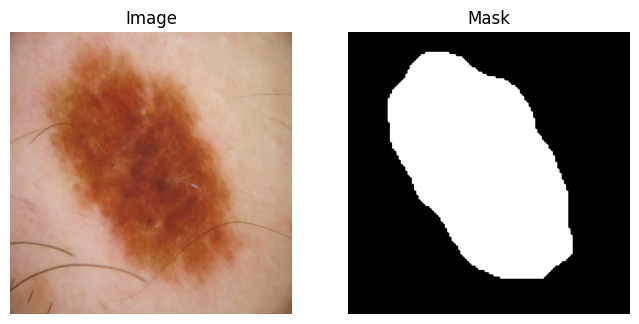

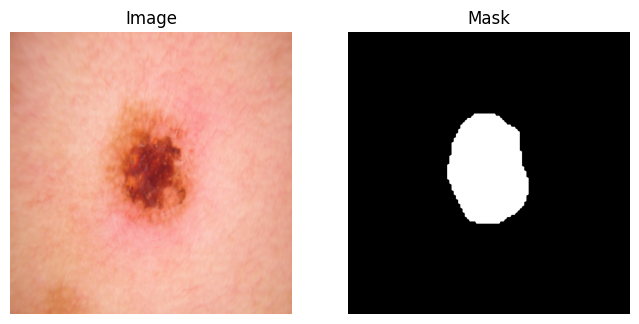

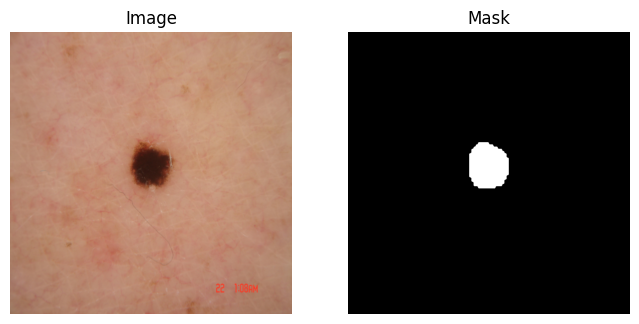

In [ ]:
import matplotlib.pyplot as plt

def show_examples(dataset, n=3):
    for i in range(n):
        img, mask = dataset[i]
        for c in range(3):
            img[c] = img[c] * IMG_STD[c] + IMG_MEAN[c]

        img_np = img.permute(1, 2, 0).numpy()  # (C,H,W) -> (H,W,C)
        mask_np = mask.squeeze(0).numpy()      # (1,H,W) -> (H,W)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(img_np)
        ax[0].set_title("Image")
        ax[0].axis('off')

        ax[1].imshow(mask_np, cmap='gray')
        ax[1].set_title("Mask")
        ax[1].axis('off')

        plt.show()

# Show 3 examples from the training dataset
show_examples(test_ds, n=3)


### Model definition

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Segformer(
    encoder_name="mit_b0",        # small, fast Transformer encoder
    encoder_weights="imagenet",   # pretrained weights
    in_channels=3,                # RGB input
    classes=1                     # binary output mask
)

### Model training

In [ ]:
# --- Model initialization ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- Scheduler & Early stopping ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
patience = 10
best_val_loss = float("inf")
epochs_no_improve = 0

# --- Training loop ---
n_epochs = 100
train_losses, val_losses = [], []
train_dices, val_dices = [], []

for epoch in range(n_epochs):
    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0.0
    train_dice = 0.0
    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch [{epoch+1}/{n_epochs}]")

    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coefficient(outputs, masks)

        loop.set_postfix(loss=loss.item(), dice=dice_coefficient(outputs, masks))

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)
    train_losses.append(train_loss)
    train_dices.append(train_dice)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_dice += dice_coefficient(outputs, masks)

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_losses.append(val_loss)
    val_dices.append(val_dice)

    scheduler.step(val_loss)

    print(f"\nEpoch [{epoch+1}/{n_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

    # ---------------- EARLY STOPPING ----------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model_segformer.pth")
        print("💾 Saved new best model.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("🛑 Early stopping triggered!")
        break


cuda


Epoch [1/100]: 100%|██████████| 25/25 [02:23<00:00,  5.75s/it, dice=0.873, loss=0.181]



Epoch [1/100] | Train Loss: 0.4444 | Train Dice: 0.7401 | Val Loss: 0.2755 | Val Dice: 0.8442
💾 Saved new best model.


Epoch [2/100]: 100%|██████████| 25/25 [02:22<00:00,  5.69s/it, dice=0.821, loss=0.211]



Epoch [2/100] | Train Loss: 0.1927 | Train Dice: 0.8606 | Val Loss: 0.1488 | Val Dice: 0.8925
💾 Saved new best model.


Epoch [3/100]: 100%|██████████| 25/25 [02:21<00:00,  5.64s/it, dice=0.873, loss=0.131]



Epoch [3/100] | Train Loss: 0.1666 | Train Dice: 0.8691 | Val Loss: 0.1570 | Val Dice: 0.8941
No improvement for 1 epoch(s).


Epoch [4/100]: 100%|██████████| 25/25 [02:23<00:00,  5.74s/it, dice=0.926, loss=0.109] 



Epoch [4/100] | Train Loss: 0.1573 | Train Dice: 0.8807 | Val Loss: 0.1086 | Val Dice: 0.8975
💾 Saved new best model.


Epoch [5/100]: 100%|██████████| 25/25 [02:21<00:00,  5.66s/it, dice=0.873, loss=0.172]



Epoch [5/100] | Train Loss: 0.1355 | Train Dice: 0.8852 | Val Loss: 0.1279 | Val Dice: 0.9106
No improvement for 1 epoch(s).


Epoch [6/100]: 100%|██████████| 25/25 [02:22<00:00,  5.72s/it, dice=0.922, loss=0.11]  



Epoch [6/100] | Train Loss: 0.1330 | Train Dice: 0.8891 | Val Loss: 0.1013 | Val Dice: 0.9150
💾 Saved new best model.


Epoch [7/100]: 100%|██████████| 25/25 [02:21<00:00,  5.64s/it, dice=0.928, loss=0.112] 



Epoch [7/100] | Train Loss: 0.1232 | Train Dice: 0.8981 | Val Loss: 0.1019 | Val Dice: 0.9069
No improvement for 1 epoch(s).


Epoch [8/100]: 100%|██████████| 25/25 [02:22<00:00,  5.70s/it, dice=0.933, loss=0.0954]



Epoch [8/100] | Train Loss: 0.1165 | Train Dice: 0.9041 | Val Loss: 0.1043 | Val Dice: 0.9155
No improvement for 2 epoch(s).


Epoch [9/100]: 100%|██████████| 25/25 [02:21<00:00,  5.67s/it, dice=0.908, loss=0.114] 



Epoch [9/100] | Train Loss: 0.1102 | Train Dice: 0.9056 | Val Loss: 0.0990 | Val Dice: 0.9184
💾 Saved new best model.


Epoch [10/100]: 100%|██████████| 25/25 [02:23<00:00,  5.72s/it, dice=0.869, loss=0.104] 



Epoch [10/100] | Train Loss: 0.1113 | Train Dice: 0.9035 | Val Loss: 0.1018 | Val Dice: 0.9128
No improvement for 1 epoch(s).


Epoch [11/100]: 100%|██████████| 25/25 [02:22<00:00,  5.70s/it, dice=0.934, loss=0.0825]



Epoch [11/100] | Train Loss: 0.1063 | Train Dice: 0.9107 | Val Loss: 0.1005 | Val Dice: 0.9165
No improvement for 2 epoch(s).


Epoch [12/100]: 100%|██████████| 25/25 [02:23<00:00,  5.73s/it, dice=0.94, loss=0.0753] 



Epoch [12/100] | Train Loss: 0.0969 | Train Dice: 0.9155 | Val Loss: 0.1023 | Val Dice: 0.9162
No improvement for 3 epoch(s).


Epoch [13/100]: 100%|██████████| 25/25 [02:22<00:00,  5.69s/it, dice=0.937, loss=0.0986]



Epoch [13/100] | Train Loss: 0.0908 | Train Dice: 0.9152 | Val Loss: 0.1021 | Val Dice: 0.9115
No improvement for 4 epoch(s).


Epoch [14/100]: 100%|██████████| 25/25 [02:22<00:00,  5.69s/it, dice=0.875, loss=0.122] 



Epoch [14/100] | Train Loss: 0.0922 | Train Dice: 0.9165 | Val Loss: 0.0919 | Val Dice: 0.9141
💾 Saved new best model.


Epoch [15/100]: 100%|██████████| 25/25 [02:22<00:00,  5.68s/it, dice=0.894, loss=0.105] 



Epoch [15/100] | Train Loss: 0.0876 | Train Dice: 0.9188 | Val Loss: 0.0922 | Val Dice: 0.9183
No improvement for 1 epoch(s).


Epoch [16/100]: 100%|██████████| 25/25 [02:23<00:00,  5.75s/it, dice=0.934, loss=0.0691]



Epoch [16/100] | Train Loss: 0.0853 | Train Dice: 0.9264 | Val Loss: 0.1029 | Val Dice: 0.9201
No improvement for 2 epoch(s).


Epoch [17/100]: 100%|██████████| 25/25 [02:21<00:00,  5.68s/it, dice=0.923, loss=0.0908]



Epoch [17/100] | Train Loss: 0.0940 | Train Dice: 0.9173 | Val Loss: 0.1166 | Val Dice: 0.9112
No improvement for 3 epoch(s).


Epoch [18/100]: 100%|██████████| 25/25 [02:22<00:00,  5.70s/it, dice=0.929, loss=0.0797]



Epoch [18/100] | Train Loss: 0.0858 | Train Dice: 0.9225 | Val Loss: 0.1066 | Val Dice: 0.9133
No improvement for 4 epoch(s).


Epoch [19/100]: 100%|██████████| 25/25 [02:21<00:00,  5.67s/it, dice=0.932, loss=0.0863]



Epoch [19/100] | Train Loss: 0.0826 | Train Dice: 0.9280 | Val Loss: 0.1077 | Val Dice: 0.9101
No improvement for 5 epoch(s).


Epoch [20/100]: 100%|██████████| 25/25 [02:22<00:00,  5.69s/it, dice=0.944, loss=0.0792]



Epoch [20/100] | Train Loss: 0.0779 | Train Dice: 0.9304 | Val Loss: 0.0968 | Val Dice: 0.9172
No improvement for 6 epoch(s).


Epoch [21/100]: 100%|██████████| 25/25 [02:21<00:00,  5.66s/it, dice=0.945, loss=0.057] 



Epoch [21/100] | Train Loss: 0.0742 | Train Dice: 0.9313 | Val Loss: 0.1013 | Val Dice: 0.9165
No improvement for 7 epoch(s).


Epoch [22/100]: 100%|██████████| 25/25 [02:21<00:00,  5.67s/it, dice=0.934, loss=0.0994]



Epoch [22/100] | Train Loss: 0.0702 | Train Dice: 0.9361 | Val Loss: 0.1033 | Val Dice: 0.9179
No improvement for 8 epoch(s).


Epoch [23/100]: 100%|██████████| 25/25 [02:21<00:00,  5.67s/it, dice=0.941, loss=0.0712]



Epoch [23/100] | Train Loss: 0.0710 | Train Dice: 0.9376 | Val Loss: 0.1021 | Val Dice: 0.9187
No improvement for 9 epoch(s).


Epoch [24/100]: 100%|██████████| 25/25 [02:22<00:00,  5.68s/it, dice=0.931, loss=0.0689]



Epoch [24/100] | Train Loss: 0.0683 | Train Dice: 0.9383 | Val Loss: 0.1038 | Val Dice: 0.9152
No improvement for 10 epoch(s).
🛑 Early stopping triggered!


### Model evaluation

cuda


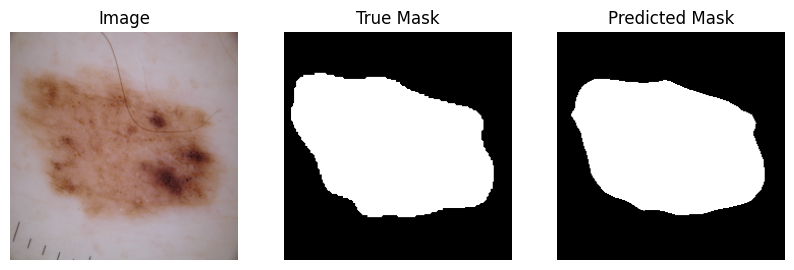

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Segformer(
    encoder_name="mit_b0",        # small, fast Transformer encoder
    encoder_weights="imagenet",   # pretrained weights
    in_channels=3,                # RGB input
    classes=1                     # binary output mask
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.load_state_dict(torch.load(r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/best_model_segformer.pth"))
model = model.to(device)

model.eval()

with torch.no_grad():
    img, true_mask = test_ds[0]
    input_tensor = img.unsqueeze(0).to(device)
    output = model(input_tensor)
    pred_mask = torch.sigmoid(output[0,0]).cpu().numpy()

# Threshold to binary
binary_mask = (pred_mask > 0.5).astype("uint8")

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img.permute(1,2,0)); plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(true_mask.squeeze(), cmap="gray"); plt.title("True Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(binary_mask, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
plt.show()


In [ ]:
def predict_scores(dataset):
    dice_scores = []
    iou_scores = []

    model.eval()
    with torch.no_grad():
        for img, true_mask in tqdm(dataset, desc="Evaluating"):
            # Move image to device
            input_tensor = img.unsqueeze(0).to(device)

            # Forward pass
            output = model(input_tensor)
            pred_mask = torch.sigmoid(output)[0, 0].cpu().numpy()

            # Binarize predictions and ground truth
            pred_bin = (pred_mask > 0.5).astype(np.uint8)
            true_bin = true_mask.squeeze().numpy().astype(np.uint8)

            # Compute metrics
            dice = dice_score(pred_bin, true_bin)
            iou = iou_score(pred_bin, true_bin)

            dice_scores.append(dice)
            iou_scores.append(iou)

    # --- PRINT RESULTS ---

    print(f"Mean Dice Score: {np.mean(dice_scores):.2f}")
    print(f"Mean IoU Score:  {np.mean(iou_scores):.2f}")

In [ ]:
print("TRAINING")
predict_scores(train_ds)
print("\nVALIDATION")
predict_scores(val_ds)
print("\nTEST")
predict_scores(test_ds)

TRAINING


Evaluating: 100%|██████████| 800/800 [01:20<00:00,  9.94it/s]


Mean Dice Score: 0.81
Mean IoU Score:  0.72

VALIDATION


Evaluating: 100%|██████████| 100/100 [00:09<00:00, 10.75it/s]


Mean Dice Score: 0.79
Mean IoU Score:  0.70

TEST


Evaluating: 100%|██████████| 100/100 [00:09<00:00, 10.21it/s]

Mean Dice Score: 0.79
Mean IoU Score:  0.70


cuda


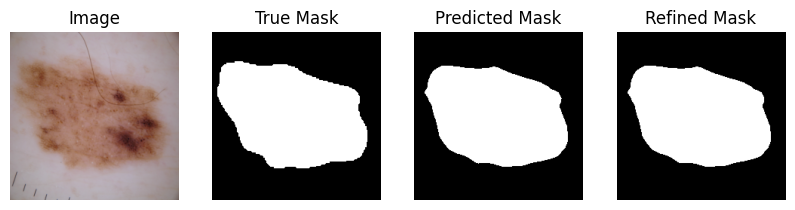

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Segformer(
    encoder_name="mit_b0",        # small, fast Transformer encoder
    encoder_weights="imagenet",   # pretrained weights
    in_channels=3,                # RGB input
    classes=1                     # binary output mask
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.load_state_dict(torch.load(r"/content/drive/MyDrive/AI_Practical_Sessions_25_26/Lesson_6/best_model_segformer.pth"))
model = model.to(device)

model.eval()

with torch.no_grad():
    img, true_mask = test_ds[0]
    input_tensor = img.unsqueeze(0).to(device)
    output = model(input_tensor)
    pred_mask = torch.sigmoid(output[0,0]).cpu().numpy()

# Threshold to binary
binary_mask = (pred_mask > 0.5).astype("uint8")

# --- Morphological refinement ---
filled_mask = ndi.binary_fill_holes(binary_mask)        # fill internal holes
clean_mask = ndi.binary_opening(filled_mask, structure=np.ones((3,3)))  # remove small noise
clean_mask = ndi.binary_closing(clean_mask, structure=np.ones((5,5)))   # close small gaps

refined_mask = clean_mask.astype("uint8")

plt.figure(figsize=(10,4))
plt.subplot(1,4,1); plt.imshow(img.permute(1,2,0)); plt.title("Image"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(true_mask.squeeze(), cmap="gray"); plt.title("True Mask"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(binary_mask, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(refined_mask, cmap="gray"); plt.title("Refined Mask"); plt.axis("off")
plt.show()

In [ ]:
def predict_scores_new(dataset):
    dice_scores = []
    iou_scores = []

    model.eval()
    with torch.no_grad():
        for img, true_mask in tqdm(dataset, desc="Evaluating"):
            # Move image to device
            input_tensor = img.unsqueeze(0).to(device)

            # Forward pass
            output = model(input_tensor)
            pred_mask = torch.sigmoid(output)[0, 0].cpu().numpy()

            # Binarize predictions and ground truth
            pred_bin = (pred_mask > 0.5).astype(np.uint8)
            true_bin = true_mask.squeeze().numpy().astype(np.uint8)

            # --- Morphological refinement ---
            filled_mask = ndi.binary_fill_holes(pred_bin)        # fill internal holes
            clean_mask = ndi.binary_opening(filled_mask, structure=np.ones((3,3)))  # remove small noise
            clean_mask = ndi.binary_closing(clean_mask, structure=np.ones((5,5)))   # close small gaps
            refined_mask = clean_mask.astype("uint8")

            # Compute metrics
            dice = dice_score(refined_mask, true_bin)
            iou = iou_score(refined_mask, true_bin)

            dice_scores.append(dice)
            iou_scores.append(iou)

    # --- PRINT RESULTS ---

    print(f"Mean Dice Score: {np.mean(dice_scores):.2f}")
    print(f"Mean IoU Score:  {np.mean(iou_scores):.2f}")

In [ ]:
print("TRAINING")
predict_scores_new(train_ds)
print("\nVALIDATION")
predict_scores_new(val_ds)
print("\nTEST")
predict_scores_new(test_ds)

TRAINING


Evaluating: 100%|██████████| 800/800 [01:22<00:00,  9.71it/s]


Mean Dice Score: 0.81
Mean IoU Score:  0.72

VALIDATION


Evaluating: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


Mean Dice Score: 0.79
Mean IoU Score:  0.70

TEST


Evaluating: 100%|██████████| 100/100 [00:10<00:00,  9.67it/s]

Mean Dice Score: 0.79
Mean IoU Score:  0.70


# end